In [1]:
# to run this notebook:
# 1) install the free Anaconda environment (https://www.continuum.io/downloads) to get latest Python 
#    and several scientific modules in one shot
# 2) download this .ipynb file plus the associated data files from github
# 3) ope this notebook entering    jupyter notebook fit-baseline.ipynb
# 4) select menu "Cell / Run all"  to execute all the notebook steps

In [2]:
import numpy as np
import matplotlib as mpl
# Force matplotlib to not use any Xwindows backend.
mpl.use('Agg')
import matplotlib.pyplot as plt


In [3]:
%matplotlib inline

In [4]:
scanname = "baseline"
metaname = scanname + '.met'
fname = scanname + '.bin'

with open(metaname, 'r') as f:
    linein = f.readline()
    inflds = linein.split()
    metaCols = int(inflds[0])
    linein = f.readline()
    inflds = linein.split()
    metaRows = int(inflds[0])
    linein = f.readline()
    inflds = linein.split()
    startFreq = int(inflds[0])
    linein = f.readline()
    inflds = linein.split()
    endFreq = int(inflds[0])
    linein = f.readline()
    inflds = linein.split()
    stepFreq = int(inflds[0])


In [5]:
bl = np.fromfile(fname, dtype='float32')
thismin = bl.min()
thismax = bl.max()

print( 'Baseline signal range: min %.2f .. max %.2f' % (thismin, thismax) )
print( 'Baseline values: %d' % ( len(bl) ) )

Baseline signal range: min -68.64 .. max -60.07
Baseline values: 1360


In [6]:
stFreq = (endFreq - startFreq) / metaCols

def frange(start, stop, step):
    i = 0
    while (i*step + start < stop):
        yield i*step + start
        i += 1

# x are the frequencies and y are pwr dB from the single scan FFT :
x = np.empty(shape=[0, 1])
for flab in frange(startFreq, endFreq, stFreq):
    x = np.append(x, flab)


In [7]:
# now we get the fit coefficients:
polynomialOrder = 7
z = np.polyfit(x, bl, polynomialOrder)

# and we get an handy function based on those coefficients:
p = np.poly1d(z)

# so that we can instantly get the full set of interpolated y for all the x:
fp = p(x)


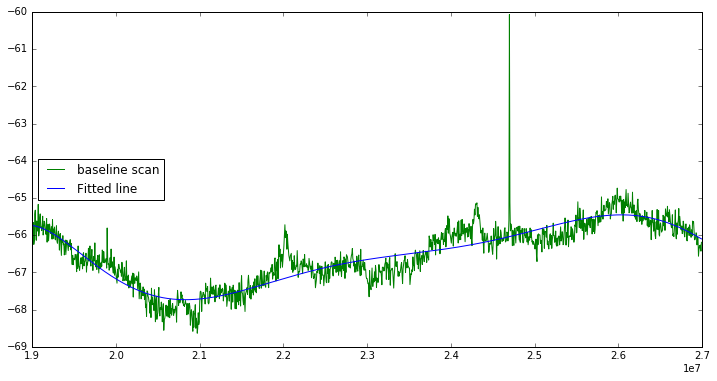

In [8]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x, bl, 'green', label='baseline scan')
plt.plot(x, fp, 'blue', label='Fitted line')
plt.legend(loc='center left')
#plt.savefig("baseline.png")
plt.savefig('baseline.png', dpi=300, transparent=False, bbox_inches='tight')

In [9]:
# we save on disk the fitted baseline for later usage

In [10]:
# here in binary format:
fd = open('newbase.bin', 'wb')
fd.write(np.float32(fp))
fd.close()

In [11]:
# here in text format compatible with rtl-power-fftw:
fd = open('newbase.dat', 'w')
for flab in frange(startFreq, endFreq, stFreq):
    outrow = "%f %f\n" % (flab, p(flab))
    fd.write(outrow)
fd.close()

In [12]:
# now we get the actual scan data:
fname = 'scan.bin'
y = np.fromfile(fname, dtype='float32')
thismin=y.min()
thismax=y.max()

print( 'scan signal range: min %.2f .. max %.2f' % (thismin, thismax) )

scan signal range: min -68.33 .. max -59.97


In [13]:
# we subtract the fitted baseline from the scan data:
differ = y - fp

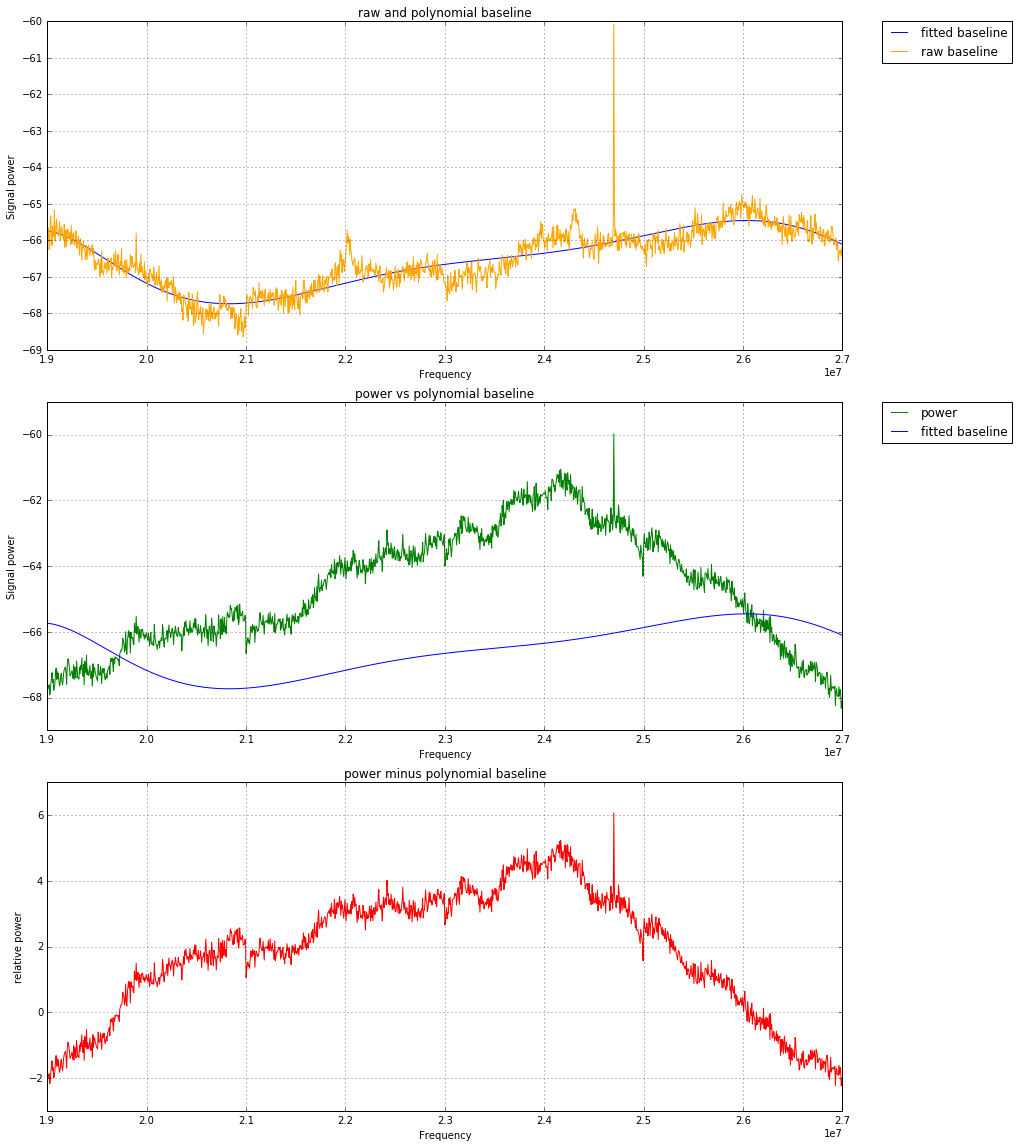

In [14]:
# and we plot all of them for easier comparison:
fig = plt.figure(figsize=(12,16))

plt.subplot(311)
plt.title('raw and polynomial baseline')
plt.plot(x, fp, 'blue', label='fitted baseline')
plt.plot(x, bl, 'orange', label='raw baseline')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Signal power')
plt.xlabel('Frequency')

plt.subplot(312)
plt.title('power vs polynomial baseline')
plt.plot(x, y, 'green', label='power')
plt.plot(x, fp, 'blue', label='fitted baseline')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Signal power')
plt.xlabel('Frequency')

plt.subplot(313)
plt.title('power minus polynomial baseline')
plt.plot(x, differ, 'red', label='power - polynomial')
plt.grid(True)
plt.ylabel('relative power')
plt.xlabel('Frequency')

plt.tight_layout()
plt.savefig('scan.png', dpi=300, transparent=False, bbox_inches='tight')

In [15]:
# now we test baseline subtraction on a 15 minutes spectrogram

In [16]:
scanname = "scan-e15m"
metaname = scanname + '.met'
fname = scanname + '.bin'

with open(metaname, 'r') as f:
    linein = f.readline()
    inflds = linein.split()
    metaCols = int(inflds[0])
    linein = f.readline()
    inflds = linein.split()
    metaRows = int(inflds[0])


In [17]:
# read in the scan data:
y = np.fromfile(fname, dtype='float32')

# and reorganize as matrix: 
y = y.reshape(metaRows, metaCols)

# this just to see the different ranges:
print(y.min(), y.max())
ys = y - fp
print(ys.min(), ys.max())

# rotate both spectrums to match the way matplotlib works:
y = np.rot90(y,1)
y = np.flipud(y)

ys = np.rot90(ys,1)
ys = np.flipud(ys)

-68.9337 -58.4509
-2.96808338235 7.58805773873


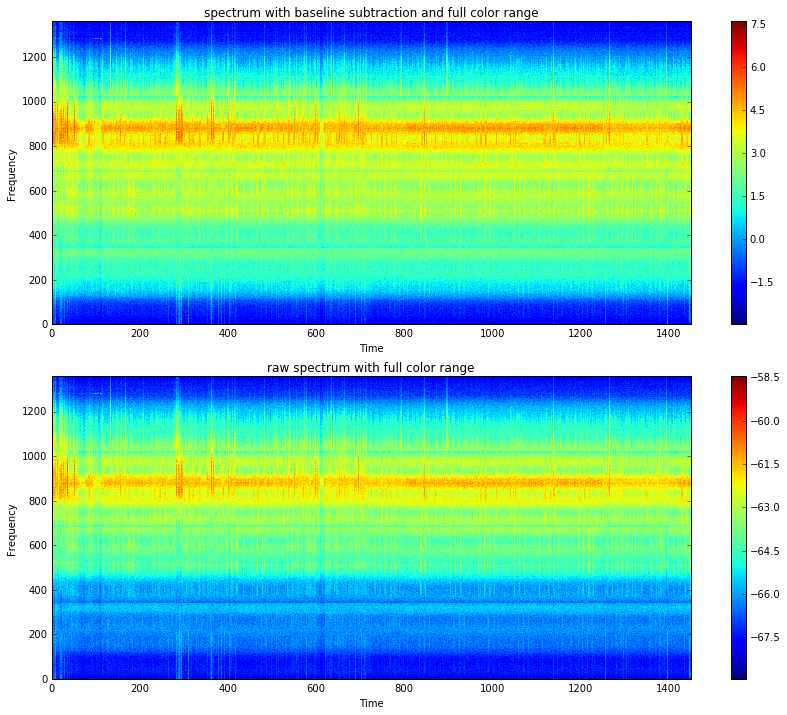

In [18]:
# and we plot the 2 spectrograms for comparison:
cmapname = 'jet'

theExtent = [1,metaRows,1,metaCols]

fig = plt.figure(figsize=(12,10))

plt.subplot(211)
plt.title('spectrum with baseline subtraction and full color range')
plt.imshow(ys, interpolation='nearest', origin='lower', extent=theExtent, aspect='auto', cmap=plt.get_cmap(cmapname) )
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()
plt.tight_layout()

plt.subplot(212)
plt.title('raw spectrum with full color range')
plt.imshow(y, interpolation='nearest', origin='lower', extent=theExtent, aspect='auto', cmap=plt.get_cmap(cmapname) )
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()
plt.tight_layout()

plt.savefig('spectrum.png', dpi=300, transparent=False, bbox_inches='tight')

In [19]:
# final note about the "signal" recorded: it's the RFI produced by the switching power supply of my laptop :-)

# on y : same frequency range of previous charts 19-27 MHz,  5600 Hz per FFT bin (row), 1360 bins
# on x: scan number (1 scan every 0.1 seconds of integration time)